In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import numpy as np
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
# !rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-16 04:40:25.819761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 04:40:25.904326: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 04:40:26.399056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_ensemble


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_xgb.head()

,series_id,step,score,event
0,038441c925bb,467,0.009440,wakeup
1,038441c925bb,467,0.001777,onset
2,038441c925bb,491,-0.034236,wakeup
3,038441c925bb,491,-0.002437,onset
4,038441c925bb,515,0.012332,wakeup


In [3]:
oof_lgb = pd.read_csv(f'/kaggle/output/{CFG["lgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_lgb.head()

,series_id,step,score,event
0,038441c925bb,467,0.037770,wakeup
1,038441c925bb,467,-0.005550,onset
2,038441c925bb,491,0.022375,wakeup
3,038441c925bb,491,-0.007494,onset
4,038441c925bb,515,0.080513,wakeup


In [4]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004654,0.000332
1,05e1944c3818,18,0.003008,0.000308
2,05e1944c3818,30,0.002308,0.000296
3,05e1944c3818,42,0.001987,0.000282
4,05e1944c3818,54,0.001864,0.000265


In [5]:
oof_wave = pd.read_parquet(f'/kaggle/output/{CFG["patch_wavenet_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_wave.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.016133,0.000098
1,05e1944c3818,18,0.014258,0.000090
2,05e1944c3818,30,0.006009,0.000092
3,05e1944c3818,42,0.005559,0.000091
4,05e1944c3818,54,0.005457,0.000100


In [6]:
oof_1d = pd.read_parquet(f'/kaggle/output/{CFG["patch_1dcnn_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_1d.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.004375,0.000344
1,05e1944c3818,18,0.002696,0.000303
2,05e1944c3818,30,0.002196,0.000266
3,05e1944c3818,42,0.001961,0.000239
4,05e1944c3818,54,0.001900,0.000221


In [7]:
oof_tubo_based = pd.read_parquet(f'/kaggle/output/tubo_based/exp019_oof.parquet')
oof_tubo_based.head()

,series_id,step,onset_oof,wakeup_oof
0,05e1944c3818,0,0.033760,0.012846
1,05e1944c3818,1,0.026779,0.009975
2,05e1944c3818,2,0.012798,0.004220
3,05e1944c3818,3,0.005708,0.001657
4,05e1944c3818,4,0.005488,0.002279


In [8]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()

In [9]:
score_dfs = []
for seires_id, df_tubo in tqdm(oof_tubo_based.groupby("series_id")):
    """
    single
    """
    df_gru = oof_gru[oof_gru["series_id"]==seires_id].reset_index(drop=True)
    df_wave = oof_wave[oof_wave["series_id"]==seires_id].reset_index(drop=True)
    df_1d = oof_1d[oof_1d["series_id"]==seires_id].reset_index(drop=True)
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id].reset_index(drop=True)
    df_lgb = oof_lgb[oof_lgb["series_id"]==seires_id].reset_index(drop=True)
    df_tubo = df_tubo[df_tubo["step"] % 12 == 6].reset_index(drop=True)

    df_label = labels[labels["series_id"]==seires_id].reset_index(drop=True)

    """
    ensemble
    """
    df = df_tubo.copy()

    # tubo based
    df["onset_oof_tubo_based"] = df["onset_oof"] / 1.5
    df["wakeup_oof_tubo_based"] = df["wakeup_oof"] / 1.5

    # gru
    df["onset_oof_gru"] = df["step"].map(df_gru.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_gru"] = df["step"].map(df_gru.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # wave
    df["onset_oof_wave"] = df["step"].map(df_wave.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_wave"] = df["step"].map(df_wave.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # 1d
    df["onset_oof_1d"] = df["step"].map(df_1d.set_index("step")["onset_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    df["wakeup_oof_1d"] = df["step"].map(df_1d.set_index("step")["wakeup_oof"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # xgb
    xgb_wakeup = df_xgb[df_xgb["event"]=="wakeup"]
    df["wakeup_oof_xgb"] = df["step"].map(xgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    xgb_onset = df_xgb[df_xgb["event"]=="onset"]
    df["onset_oof_xgb"] = df["step"].map(xgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # lgb
    lgb_wakeup = df_lgb[df_lgb["event"]=="wakeup"]
    df["wakeup_oof_lgb"] = df["step"].map(lgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    lgb_onset = df_lgb[df_lgb["event"]=="onset"]
    df["onset_oof_lgb"] = df["step"].map(lgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    
    df["wakeup_oof"] = (
          df["wakeup_oof_gru"] * 0.17
        + df["wakeup_oof_wave"] * 0.17
        + df["wakeup_oof_1d"] * 0.17
        + df["wakeup_oof_xgb"] * 0.1 
        + df["wakeup_oof_lgb"] * 0.1
        + df["wakeup_oof_tubo_based"] * 0.3
    )
    df["onset_oof"] = (
          df["onset_oof_gru"] * 0.17
        + df["onset_oof_wave"] * 0.17
        + df["onset_oof_1d"] * 0.17
        + df["onset_oof_xgb"] * 0.1 
        + df["onset_oof_lgb"] * 0.1 
        + df["onset_oof_tubo_based"] * 0.3
    )
    df_ens = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)

    """
    score
    """
    scores = []
    for this_df in [df_gru, df_wave, df_1d, df_xgb, df_lgb, df_tubo, df_ens]:
        if "event" not in this_df.columns:
            dfs = []
            df = this_df[["series_id", "step", "wakeup_oof"]].copy()
            df["event"] = "wakeup"
            df["score"] = df["wakeup_oof"]
            dfs.append(df[['series_id', 'step', 'event', 'score']])

            df = this_df[["series_id", "step", "onset_oof"]].copy()
            df["event"] = "onset"
            df["score"] = df["onset_oof"]
            dfs.append(df[['series_id', 'step', 'event', 'score']])

            this_df = pd.concat(dfs)
        this_df["step"] = this_df["step"].astype(int)
        this_df = this_df[this_df["score"]>0.005].reset_index(drop=True)
        sub = dynamic_range_nms(this_df)
        sub["score"] = sub["reduced_score"]

        if df_label.shape[0] == 0:
            score = np.nan
        else:
            score, _ = compute_comptetition_metric(df_label, sub)
        scores.append(score)
    
    n_day = max(df_gru["step"].max(), df_wave["step"].max(), df_1d["step"].max(), df_xgb["step"].max(), df_lgb["step"].max(), df_tubo["step"].max())
    n_day /= 12 * 60 * 24
    n_label = len(df_label)
    p_label = n_label / n_day / 2

    score_df = pd.DataFrame({
        "series_id": seires_id,
        "n_day": n_day,
        "n_label": n_label,
        "p_label": p_label,
        "transformer": scores[0],
        "wave": scores[1],
        "1d": scores[2],
        "xgb": scores[3],
        "lgb": scores[4],
        "tubo": scores[5],
        "ensemble": scores[6],
    }, index=[0])
    score_dfs.append(score_df)
    # break
score_df = pd.concat(score_dfs).reset_index(drop=True)
score_df

100%|██████████| 277/277 [16:52<00:00,  3.66s/it]


,series_id,n_day,n_label,p_label,transformer,wave,1d,xgb,lgb,tubo,ensemble
0,038441c925bb,22.832986,38,0.832129,0.772803,0.824454,0.765522,0.789734,0.780563,0.734776,0.799216
1,03d92c9f6f8a,42.166319,16,0.189725,0.903726,0.923833,0.915414,0.852381,0.860974,0.868217,0.917563
2,0402a003dae9,23.249653,36,0.774205,0.747424,0.761417,0.791200,0.754849,0.743213,0.751966,0.784689
3,04f547b8017d,37.166319,42,0.565028,0.896901,0.892116,0.902214,0.888102,0.892393,0.885246,0.915891
4,05e1944c3818,23.499653,14,0.297877,0.310147,0.311826,0.329530,0.358828,0.387803,0.305945,0.320487
...,...,...,...,...,...,...,...,...,...,...,...
272,fa149c3c4bde,23.832986,32,0.671338,0.687079,0.714307,0.692726,0.720236,0.707737,0.658013,0.705900
273,fb223ed2278c,53.416319,10,0.093604,0.719113,0.693130,0.645562,0.666889,0.658698,0.613439,0.682474
274,fbf33b1a2c10,24.666319,40,0.810822,0.637328,0.610076,0.637302,0.637791,0.628142,0.639279,0.630636
275,fcca183903b7,36.166319,70,0.967751,0.846720,0.865996,0.876907,0.860720,0.858829,0.850091,0.862816


In [10]:
score_df.to_csv(f"{CFG['output_dir']}/series_score.csv", index=False)

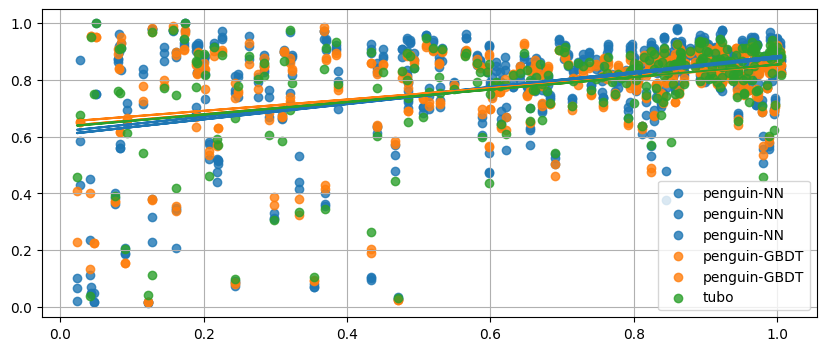

In [22]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(10, 4))
cmap = plt.get_cmap("tab10")

for c in ["transformer", "wave", "1d",]:
    plt.scatter(score_df["p_label"], score_df[c], label="penguin-NN", color=cmap(0), alpha=0.8)

    # 回帰直線
    x = score_df[~score_df[c].isna()]["p_label"]
    y = score_df[~score_df[c].isna()][c]
    a, b = np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color=cmap(0))

for c in ["xgb", "lgb"]:
    plt.scatter(score_df["p_label"], score_df[c], label="penguin-GBDT", color=cmap(1), alpha=0.8)
    
    # 回帰直線
    x = score_df[~score_df[c].isna()]["p_label"]
    y = score_df[~score_df[c].isna()][c]
    a, b = np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color=cmap(1))

for c in ["tubo"]:
    plt.scatter(score_df["p_label"], score_df[c], label="tubo", color=cmap(2), alpha=0.8)
    
    # 回帰直線
    x = score_df[~score_df[c].isna()]["p_label"]
    y = score_df[~score_df[c].isna()][c]
    a, b = np.polyfit(x, y, 1)
    plt.plot(x, a*x+b, color=cmap(2))


# for c in ["ensemble"]:
#     plt.scatter(score_df["p_label"], score_df[c], label="tubo", color=cmap(3), alpha=0.1)
    
#     # 回帰直線
#     x = score_df[~score_df[c].isna()]["p_label"]
#     y = score_df[~score_df[c].isna()][c]
#     a, b = np.polyfit(x, y, 1)
#     plt.plot(x, a*x+b, color=cmap(3))


plt.legend()
plt.grid()
plt.show()